In [1]:
%%capture

from sz_utils import data_handler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import getpass

# check if gpu is available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

# collect the data
preictal, interictal = data_handler.make_patient_windows("chb01")

# make the labels
X = np.concatenate((preictal, interictal), axis=0)
y = np.concatenate((np.ones((preictal.shape[0], 1)), np.zeros((interictal.shape[0], 1))), axis=0)

# Shuffle the data
shuffle_indices = np.random.permutation(np.arange(X.shape[0]))
X = X[shuffle_indices]
y = y[shuffle_indices]

# Split the data into train and test
train_size = int(X.shape[0] * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Split test data into validation and test
val_size = int(X_test.shape[0] * 0.5)
X_val = X_test[:val_size]
y_val = y_test[:val_size]
X_test = X_test[val_size:]
y_test = y_test[val_size:]

2023-03-29 19:23:17.051228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 19:23:18.994410: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-03-29 19:23:18.994587: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-03-29 19:23:19.003806: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-03-29 19:23:21.693095: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


In [2]:

import numpy as np
import mlflow.tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,LSTM, Conv1D, Activation, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import AUC
import keras

In [3]:

# shapes
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape, "X_val shape:", X_val.shape, "y_val shape:", y_val.shape, "X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train shape: (672, 1280, 22) y_train shape: (672, 1) X_val shape: (84, 1280, 22) y_val shape: (84, 1) X_test shape: (84, 1280, 22) y_test shape: (84, 1)


In [4]:
num_classes = 2 
input_shape_dataset = (X_train.shape[1], X_train.shape[2])
input_shape_dataset

def create_model_cnn_basic_1_layer(
    input_shape_dataset: tuple = input_shape_dataset,
    num_classes: int = num_classes,
    debug: bool = False,
    filters: int = 256,
    kernel_size: int = 3,
    pool_size: int = 2,
    dropout: float = 0.1,
    dense_size: int = 64,
    loss: str = "binary_crossentropy",
    optimizer: str = "adam",
    metrics: list = ["accuracy"],

) -> tf.keras.Model:

    """This function creates a basic convolutional neural network model with 2 convolutional layers, 2 dense layers and a softmax layer

    :param input_shape_dataset: shape of the input data
    :type input_shape_dataset: tuple
    :param num_classes: number of classes
    :type num_classes: int
    :return: return a model
    :rtype: tf.keras.Model
    """

    if debug:
        print("------------model summary---------------")
        print("input_shape_dataset", input_shape_dataset)
        print("num_classes", num_classes)

    input_shape_dataset: tuple
    
    model = Sequential()

    model.add(Conv1D(filters, kernel_size, input_shape=(input_shape_dataset)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_size))
    model.add(Dropout(dropout))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [31]:
def create_model_mlp(
    input_shape_dataset: tuple = input_shape_dataset,
    num_classes: int = num_classes,
    debug: bool = False,
    hidden_units: int = 256,
    dropout: float = 0.1,
    loss: str = "binary_crossentropy",
    optimizer: str = "adam",
    metrics: list = ["accuracy"],
) -> tf.keras.Model:

    """This function creates a basic Multi-layer Perceptron (MLP) model with 1 hidden layer

    :param input_shape_dataset: shape of the input data
    :type input_shape_dataset: tuple
    :param num_classes: number of classes
    :type num_classes: int
    :return: return a model
    :rtype: tf.keras.Model
    """

    if debug:
        print("------------model summary---------------")
        print("input_shape_dataset", input_shape_dataset)
        print("num_classes", num_classes)

    model = Sequential()

    model.add(Flatten(input_shape=input_shape_dataset))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model


2023-03-29 19:23:42.526319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 19:23:42.528822: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce GTX 1650)
2023-03-29 19:23:44.227891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-29 19:23:44.228043: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2023-03-29 19:23:44.228434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

In [32]:
create_model_mlp()

## test artifacts

In [10]:
from dataclasses import dataclass
import tensorflow as tf
import mlflow
from sklearn.model_selection import KFold
import itertools
from sklearn.metrics import confusion_matrix

class Experiment:
    experiment_name: str
    model_name: str
    model: tf.keras.Model
    dataset: tuple
    hyperparameters: dict
    metrics: dict
    n_splits: int
    kf_metrics: dict
    kf_models: list


    def __init__(self, experiment_name, model_name, model, dataset, hyperparameters, metrics, n_splits):
        self.experiment_name = experiment_name
        self.model_name = model_name
        self.model = model
        self.dataset = dataset
        self.hyperparameters = hyperparameters
        self.metrics = metrics      
        self.n_splits = n_splits
        self.kf_metrics = {}
        self.kf_models = []

    def fit(self):
        # Add K-fold cross-validation
        kf = KFold(n_splits=self.n_splits)
        fold = 0
        for train_index, val_index in kf.split(self.dataset[0]):
            fold += 1
            print(f"Training fold {fold}/{self.n_splits}")
            X_train_fold, y_train_fold = self.dataset[0][train_index], self.dataset[1][train_index]
            X_val_fold, y_val_fold = self.dataset[0][val_index], self.dataset[1][val_index]
            mlflow.tensorflow.autolog()
            history = self.model.fit(X_train_fold, y_train_fold,
                                     validation_data=(X_val_fold, y_val_fold),
                                     epochs=self.hyperparameters["epochs"],
                                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
            # Log metrics for this fold
            self.log_metrics(history, fold=fold)
            self.kf_models.append(self.model)
        # TODO log artifacts
        mlflow.log_artifact(self._log_graphs(history), artifact_path='Artifacts')
        return history

    def set_experiment(self):
        mlflow.set_experiment(self.experiment_name)

    def log_params(self):
        mlflow.log_param("model_name", self.model_name)
        for key, value in self.hyperparameters.items():
            mlflow.log_param(key, value)

    def log_metrics(self, history, fold=None):
        for metric_name, metric_values in history.history.items():
            if metric_name not in self.kf_metrics:
                self.kf_metrics[metric_name] = []
            self.kf_metrics[metric_name].append(metric_values)
            for epoch, value in enumerate(metric_values):
                mlflow.log_metric(f"Fold_{fold}_{metric_name}", value, step=epoch)



    def _log_graphs(self, history, y_true=None, y_pred=None, artifact_path='graphs.png'):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

        # Accuracy plot
        ax[0].plot(history.history['accuracy'], label='train')
        ax[0].plot(history.history['val_accuracy'], label='val')
        ax[0].set_title('Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Accuracy')
        ax[0].legend()

        # Loss plot
        ax[1].plot(history.history['loss'], label='train')
        ax[1].plot(history.history['val_loss'], label='val')
        ax[1].set_title('Loss')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Loss')
        ax[1].legend()

        # Confusion matrix
        if y_true is not None and y_pred is not None:
            y_pred_classes = (y_pred > 0.5).astype(int)
            cm = confusion_matrix(y_true, y_pred_classes)
            classes = ['Class 0', 'Class 1'] # update with your actual class labels
            cmap=plt.cm.Blues
            ax[2].imshow(cm, interpolation='nearest', cmap=cmap)
            ax[2].set_title('Confusion Matrix')
            ax[2].set_xticks(range(len(classes)))
            ax[2].set_yticks(range(len(classes)))
            ax[2].set_xticklabels(classes, rotation=45)
            ax[2].set_yticklabels(classes)
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                ax[2].text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()

        # Save the plots to a file
        plt.tight_layout()
        plt.savefig(artifact_path)
        return artifact_path

            
    # def log_artifacts(self):
    #     # Same as before
    #     pass


In [22]:
import mlflow

def registrar_experiment(experiment: Experiment):
    with mlflow.start_run(nested=True):
        experiment.set_experiment()
        experiment.log_params()
        history = experiment.fit()
        y_pred = experiment.model.predict(X_test)
        y_true = y_test
        experiment.log_metrics(history)
        # print(graph_path)
        y_pred_classes = (y_pred > 0.5).astype(int)
        graph_path = experiment._log_graphs(history, y_true=y_true, y_pred=y_pred_classes)
        # print(graph_path)
        mlflow.log_artifact(graph_path, artifact_path='Artifacts')
        # experiment.log_artifacts()


Traceback (most recent call last):
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 279, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 372, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\utils\file_utils.py", line 182, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist."

Training fold 1/5
Epoch 1/10
 4/17 [======>.......................] - ETA: 0s - loss: 3622.6479 - accuracy: 0.5000

17/17 [==============================] - 1s 41ms/step - loss: 1565.4106 - accuracy: 0.5345 - val_loss: 420.4722 - val_accuracy: 0.5556
Epoch 2/10
17/17 [==============================] - 0s 20ms/step - loss: 62.9979 - accuracy: 0.8883 - val_loss: 64.5065 - val_accuracy: 0.8593
Epoch 3/10
17/17 [==============================] - 0s 19ms/step - loss: 15.9867 - accuracy: 0.9609 - val_loss: 20.4989 - val_accuracy: 0.9111
Epoch 4/10
17/17 [==============================] - 0s 21ms/step - loss: 3.4858 - accuracy: 0.9907 - val_loss: 13.6217 - val_accuracy: 0.9407
Epoch 5/10
17/17 [==============================] - 0s 19ms/step - loss: 1.0718 - accuracy: 0.9963 - val_loss: 2.6008 - val_accuracy: 0.9852
Epoch 6/10
17/17 [==============================] - 0s 20ms/step - loss: 3.1139e-26 - accuracy: 1.0000 - val_loss: 1.5418 - val_accuracy: 0.9852
Epoch 7/10
17/17 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4314 - val_accuracy: 0.9926
Epoch 

2023/04/02 19:04:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmpxlr41vjy\model\data\model\assets


Training fold 2/5
Epoch 1/10
 5/17 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

17/17 [==============================] - 1s 29ms/step - loss: 0.5441 - accuracy: 0.9944 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
17/17 [==============================] - 0s 18ms/step - loss: 0.2911 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
17/17 [==============================] - 0s 20ms/step - loss: 9.2422e-13 - accuracy: 1.0000 - val_loss: 1.9171e-22 - val_accuracy: 1.0000
Epoch 4/10
17/17 [==============================] - 0s 23ms/step - loss: 0.0782 - accuracy: 0.9963 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 0s 18ms/step - loss: 0.3343 - accuracy: 0.9963 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 17ms/step


2023/04/02 19:04:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmpfcnli4ji\model\data\model\assets


Training fold 3/5
Epoch 1/10
 5/17 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

17/17 [==============================] - 0s 26ms/step - loss: 8.6919e-36 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
17/17 [==============================] - 0s 20ms/step - loss: 0.0220 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
17/17 [==============================] - 0s 18ms/step - loss: 0.1947 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
17/17 [==============================] - 0s 20ms/step - loss: 4.3678e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 0s 19ms/step - loss: 0.1646 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 16ms/step


2023/04/02 19:04:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmpi0ib5rq4\model\data\model\assets


Training fold 4/5
Epoch 1/10
 5/17 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

17/17 [==============================] - 0s 24ms/step - loss: 0.1291 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
17/17 [==============================] - 0s 18ms/step - loss: 0.1438 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
17/17 [==============================] - 0s 17ms/step - loss: 0.0576 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
17/17 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 0s 18ms/step - loss: 1.8577e-26 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 16ms/step


2023/04/02 19:04:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmp3u4vu18n\model\data\model\assets


Training fold 5/5
Epoch 1/10
 5/17 [=======>......................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

17/17 [==============================] - 0s 27ms/step - loss: 7.5080e-28 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
17/17 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
17/17 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
17/17 [==============================] - 0s 18ms/step - loss: 0.0276 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 0s 18ms/step - loss: 0.4336 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 17ms/step


2023/04/02 19:04:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmphahvf_7v\model\data\model\assets


3/3 [==============================] - 0s 5ms/step


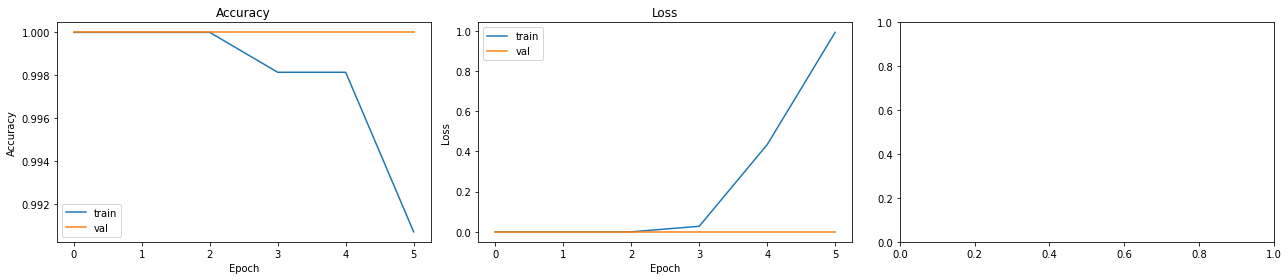

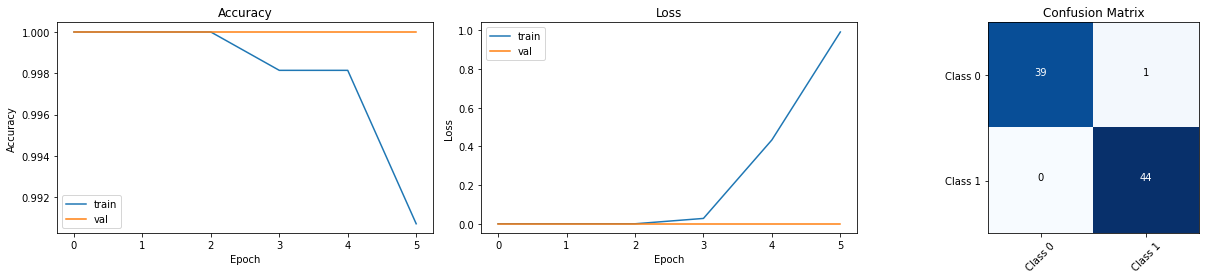

In [15]:
experiment_1 = Experiment(
    experiment_name = "CNN_autolog_experiment",
    model_name = "CNN_basic_1_layer",
    model = create_model_cnn_basic_1_layer(),
    dataset = (X_train, y_train, X_val, y_val),
    hyperparameters = {
        "epochs": 10,
        "filters": 256,
        "kernel_size": 3,
        "pool_size": 1,
        "dropout": 0.1,
        "dense_size": 32,
        "loss": "binary_crossentropy",
        "optimizer": "adam",

    },metrics = ["accuracy"],

    n_splits = 5
)

registrar_experiment(experiment_1)

Traceback (most recent call last):
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 279, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 372, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\utils\file_utils.py", line 182, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist."

Training fold 1/5
Epoch 1/20
 5/17 [=======>......................] - ETA: 0s - loss: 160.3450 - accuracy: 0.4313

17/17 [==============================] - 1s 35ms/step - loss: 193.2702 - accuracy: 0.5438 - val_loss: 194.1573 - val_accuracy: 0.6296
Epoch 2/20
17/17 [==============================] - 0s 10ms/step - loss: 35.6854 - accuracy: 0.8659 - val_loss: 152.9304 - val_accuracy: 0.6519
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 7.6659 - accuracy: 0.9497 - val_loss: 153.7508 - val_accuracy: 0.6593
Epoch 4/20
17/17 [==============================] - 0s 11ms/step - loss: 4.8173 - accuracy: 0.9758 - val_loss: 141.3276 - val_accuracy: 0.6741
Epoch 5/20
17/17 [==============================] - 0s 9ms/step - loss: 1.7150 - accuracy: 0.9814 - val_loss: 156.6990 - val_accuracy: 0.6519
Epoch 6/20
17/17 [==============================] - 0s 9ms/step - loss: 0.9771 - accuracy: 0.9907 - val_loss: 172.9714 - val_accuracy: 0.6963
Epoch 7/20
17/17 [==============================] - 0s 9ms/step - loss: 0.9038 - accuracy: 0.9907 - val_loss: 182.9901 - val_accuracy: 0.6667
Epoch 8/20


2023/04/02 19:24:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmp3l0umkl7\model\data\model\assets


Training fold 2/5
Epoch 1/20
17/17 [==============================] - 0s 14ms/step - loss: 38.4257 - accuracy: 0.9032 - val_loss: 4.5645 - val_accuracy: 0.9630
Epoch 2/20
17/17 [==============================] - 0s 9ms/step - loss: 11.0409 - accuracy: 0.9348 - val_loss: 16.5748 - val_accuracy: 0.9259
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 6.6882 - accuracy: 0.9646 - val_loss: 34.8876 - val_accuracy: 0.9037
Epoch 4/20
17/17 [==============================] - 0s 9ms/step - loss: 6.1263 - accuracy: 0.9609 - val_loss: 23.8090 - val_accuracy: 0.9037
Epoch 5/20
17/17 [==============================] - 0s 11ms/step - loss: 0.9054 - accuracy: 0.9870 - val_loss: 26.9624 - val_accuracy: 0.8889
Epoch 6/20
1/1 [==============================] - 0s 17ms/step


2023/04/02 19:24:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmpx5mtvyyn\model\data\model\assets


Training fold 3/5
Epoch 1/20
17/17 [==============================] - 0s 16ms/step - loss: 6.6368 - accuracy: 0.9572 - val_loss: 8.1227 - val_accuracy: 0.9701
Epoch 2/20
17/17 [==============================] - 0s 9ms/step - loss: 4.0230 - accuracy: 0.9703 - val_loss: 12.4541 - val_accuracy: 0.9552
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 4.9752 - accuracy: 0.9665 - val_loss: 24.0422 - val_accuracy: 0.9403
Epoch 4/20
17/17 [==============================] - 0s 9ms/step - loss: 4.1136 - accuracy: 0.9740 - val_loss: 14.1326 - val_accuracy: 0.9403
Epoch 5/20
17/17 [==============================] - 0s 9ms/step - loss: 2.1240 - accuracy: 0.9870 - val_loss: 14.2213 - val_accuracy: 0.9552
Epoch 6/20
1/1 [==============================] - 0s 20ms/step


2023/04/02 19:25:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmplu33njwl\model\data\model\assets


Training fold 4/5
Epoch 1/20
17/17 [==============================] - 0s 17ms/step - loss: 5.0164 - accuracy: 0.9721 - val_loss: 3.1051 - val_accuracy: 0.9701
Epoch 2/20
17/17 [==============================] - 0s 9ms/step - loss: 5.4411 - accuracy: 0.9647 - val_loss: 4.2017 - val_accuracy: 0.9552
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 2.6210 - accuracy: 0.9740 - val_loss: 3.1703 - val_accuracy: 0.9552
Epoch 4/20
17/17 [==============================] - 0s 10ms/step - loss: 0.5684 - accuracy: 0.9870 - val_loss: 1.6513 - val_accuracy: 0.9701
Epoch 5/20
17/17 [==============================] - 0s 9ms/step - loss: 2.1314 - accuracy: 0.9888 - val_loss: 3.8702 - val_accuracy: 0.9552
Epoch 6/20
17/17 [==============================] - 0s 10ms/step - loss: 0.4951 - accuracy: 0.9870 - val_loss: 12.9714 - val_accuracy: 0.9328
Epoch 7/20
17/17 [==============================] - 0s 10ms/step - loss: 1.8687 - accuracy: 0.9851 - val_loss: 16.4737 - val_accuracy: 0.9

2023/04/02 19:25:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmp1a6sh02b\model\data\model\assets


Training fold 5/5
Epoch 1/20
17/17 [==============================] - 0s 15ms/step - loss: 1.2858 - accuracy: 0.9870 - val_loss: 2.4277 - val_accuracy: 0.9925
Epoch 2/20
17/17 [==============================] - 0s 12ms/step - loss: 1.4570 - accuracy: 0.9833 - val_loss: 0.5085 - val_accuracy: 0.9925
Epoch 3/20
17/17 [==============================] - 0s 10ms/step - loss: 4.2693 - accuracy: 0.9777 - val_loss: 0.9153 - val_accuracy: 0.9701
Epoch 4/20
17/17 [==============================] - 0s 10ms/step - loss: 6.6415 - accuracy: 0.9740 - val_loss: 11.0347 - val_accuracy: 0.9254
Epoch 5/20
17/17 [==============================] - 0s 9ms/step - loss: 7.4078 - accuracy: 0.9647 - val_loss: 15.2022 - val_accuracy: 0.9254
Epoch 6/20
17/17 [==============================] - 0s 9ms/step - loss: 4.6518 - accuracy: 0.9721 - val_loss: 20.6963 - val_accuracy: 0.9254
Epoch 7/20
1/1 [==============================] - 0s 17ms/step


2023/04/02 19:25:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmpzem8z4sp\model\data\model\assets


3/3 [==============================] - 0s 3ms/step


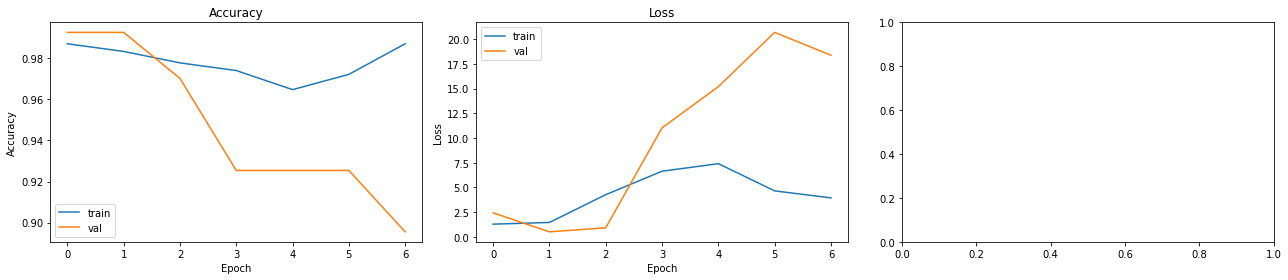

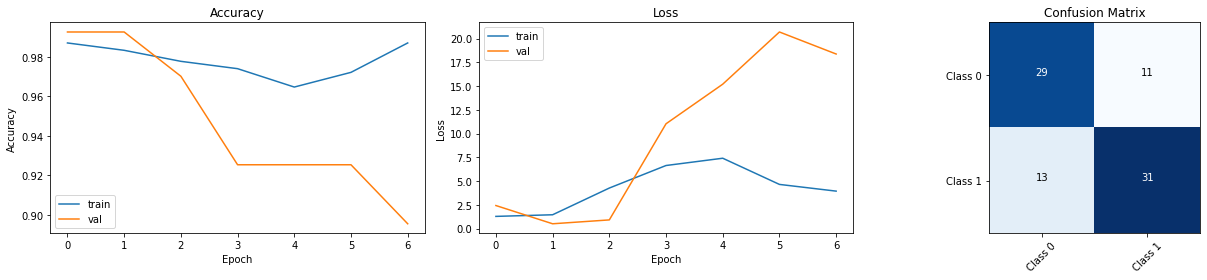

In [34]:
experiment_mlp = Experiment(
    experiment_name = "MLP_autolog_exp",
    model_name = "MLP_basic_1_layer",
    model = create_model_mlp(),
    dataset = (X_train, y_train, X_val, y_val),
    hyperparameters = {
        "epochs": 20,
        
        },
        metrics = ["accuracy"], n_splits = 5)

registrar_experiment(experiment_mlp)

In [29]:
# count values in list y_train y y_val
y_train

unique_values, counts = np.unique(y_train, return_counts=True)

print(unique_values)
print(counts)

[0. 1.]
[340 332]


In [30]:
unique_values, counts = np.unique(y_val, return_counts=True)

print(unique_values)
print(counts)

[0. 1.]
[40 44]
